In [1]:
import pyroomacoustics as pra
import numpy as np
import librosa
import soundfile
room = pra.ShoeBox([4.45, 3.55, 3.5], fs=8000)

In [2]:
import os
def white(x):
    return (x - np.mean(x))/(np.std(x))
datas = []
for i in os.listdir("./audios"):
    local_audio = librosa.load("./audios/"+i, sr=8000)[0] #max——mix_datas
    local_audio = white(local_audio)
    datas.append(local_audio)

In [3]:
r = 0.5
rx = 2.56
ry = 1.8
setas = np.asarray([45, 120, 210, 315]) #seta is the inverse angle of xy
setas = setas*np.pi/180
source_pos_x = rx + np.sin(setas)
source_pos_y = ry - np.cos(setas)
import matplotlib.pyplot as plt
plt.scatter(source_pos_x, source_pos_y)
plt.scatter(2.56, 1.8)
plt.xlim(0, 4.45)
plt.ylim(0, 3.55)
plt.show()

<Figure size 640x480 with 1 Axes>

In [4]:
#source_vec = []
for i  in range(len(source_pos_x)):
    #source_vec.append([source_pos_x[i], source_pos_y[i], 1])
    
    local_source = pra.SoundSource([source_pos_x[i], source_pos_y[i], 1.5], signal=datas[i])
    room.sources.append(local_source)

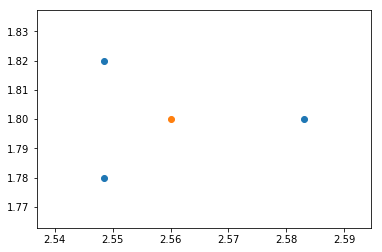

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

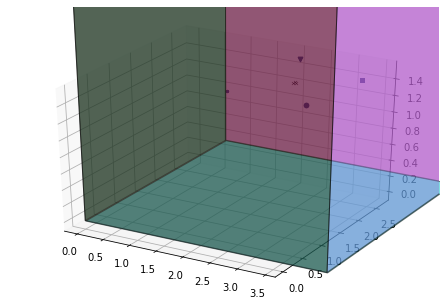

In [5]:
R = pra.beamforming.circular_2D_array(center=[2.56, 1.80], 
                                          M=3, 
                                          radius=0.04/np.sqrt(3),
                                          phi0=0
                                         )
plt.scatter(R[0], R[1])
plt.scatter(2.56, 1.80)
plt.show()
R = np.concatenate([R, np.ones([1, 3])*1.5], axis=0)

room.add_microphone_array(pra.MicrophoneArray(R, room.fs))
room.plot()
plt.show()

In [6]:
room.compute_rir()
room.simulate()
#room.simulate(reference_mic=0, snr=10)
mics_signals = room.mic_array.signals

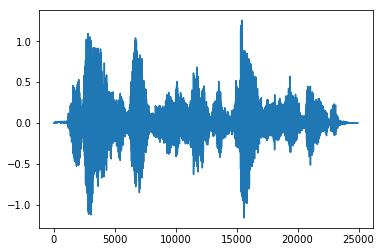

In [7]:
plt.plot(mics_signals[0])
plt.show()

In [8]:
import tensorflow as tf
tf.enable_eager_execution()
mics_signals = tf.cast(mics_signals, tf.float32)
tfbins = tf.signal.stft(
    mics_signals,
    frame_length=512,
    frame_step=int(512*1/4),
    fft_length=512,
    window_fn=tf.signal.hann_window
)
tfbins = tfbins.numpy()
tfbins = tfbins[:, :, 1:]

(3, 192, 256)


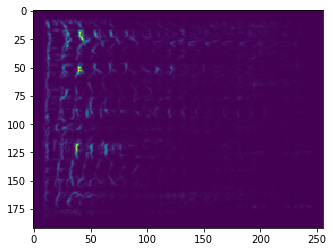

In [9]:
print(tfbins.shape)
plt.imshow(np.abs(tfbins[0]))
plt.show()

0.99856424
0.0019682576


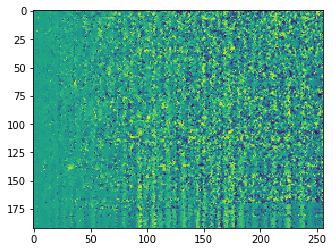

In [10]:
#caculate the A(f, t)
A = np.sqrt(np.sum(np.abs(tfbins)**2, axis=0))
divider = tf.broadcast_to(A, tfbins.shape)
seta_L = (np.abs(tfbins)/divider).numpy()
print(np.max(seta_L))
print(np.min(seta_L))
plt.imshow(seta_L[0])
plt.show()

In [11]:
#use the appropriate value of aerfa in eassy that is 4*pi/340*0.04 or 0.055
#notice use the 0th mac as the ref mac
#At the same time the seta_ will not bigger than 2*pi
#aerfa = 4*np.pi/340*0.04 # max_ phase move of tfbins
aerfa = 4/340*0.04
seta_p = np.zeros(tfbins.shape)
xj = tfbins[0]
for i in range(tfbins.shape[0]):
    for j in range(tfbins.shape[1]):
        for k in range(tfbins.shape[2]):
            seta_p[i, j, k] = np.angle(tfbins[i, j, k]/xj[j, k])/((k+1)*8000/128*aerfa)

30.6621071100235
-12.653971552848816


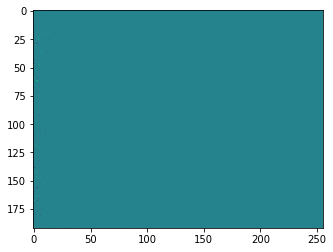

In [12]:
plt.imshow(seta_p[0])
print(np.max(seta_p))
print(np.min(seta_p))
plt.show()

In [13]:
#mix feature 2 complex number then normalize
seta_main = np.abs(seta_L)*np.exp(1j*seta_p)
for i, content in enumerate(seta_main):
    seta_main[i] = content/np.linalg.norm(content, 2)

In [14]:
#k-means clusting distance reprensnt as ck dot seta
time = seta_main.shape[1]
freq = seta_main.shape[2]
seta_clu = np.reshape(seta_main, [3, -1]).T
print(seta_clu.shape)

(49152, 3)


In [15]:
"""
k = 4
rand_idx = np.random.choice(seta_clu.shape[0], k)
centers = seta_clu[rand_idx]
def get_distant(cts, pts):
    dist = np.real(np.dot(cts.conj().T, pts))
    return dist
labels = np.ones(seta_clu.shape[0])*-1
for iter in range(50):
    print(iter)
    C = []
    for i in range(k):
        C.append([])
    for labelIndex, pts in enumerate(seta_clu):
        max_dist = 0
        class_index = -1
        for i, cts in enumerate(centers):
            dist = get_distant(cts, pts)
            if dist>max_dist:
                max_dist = dist
                classIndex = i
        C[classIndex].append(pts)
        labels[labelIndex] = classIndex
    for i, cluster in enumerate(C):
        centers[i] = np.mean(C[i], axis=0)
"""

'\nk = 4\nrand_idx = np.random.choice(seta_clu.shape[0], k)\ncenters = seta_clu[rand_idx]\ndef get_distant(cts, pts):\n    dist = np.real(np.dot(cts.conj().T, pts))\n    return dist\nlabels = np.ones(seta_clu.shape[0])*-1\nfor iter in range(50):\n    print(iter)\n    C = []\n    for i in range(k):\n        C.append([])\n    for labelIndex, pts in enumerate(seta_clu):\n        max_dist = 0\n        class_index = -1\n        for i, cts in enumerate(centers):\n            dist = get_distant(cts, pts)\n            if dist>max_dist:\n                max_dist = dist\n                classIndex = i\n        C[classIndex].append(pts)\n        labels[labelIndex] = classIndex\n    for i, cluster in enumerate(C):\n        centers[i] = np.mean(C[i], axis=0)\n'

In [16]:
from sklearn.cluster import KMeans
k=4
seta_clu_0 = np.abs(seta_clu)
seta_clu_1 = np.angle(seta_clu)
print(np.min(seta_clu_1))
print(np.max(seta_clu_1))
seta_clu_1/=np.pi
seta_clu_1 = seta_clu_1/2+1/2
seta_clu = np.concatenate([seta_clu_0, seta_clu_1], axis=-1)
kmeans = KMeans(n_clusters=k, random_state=0).fit(seta_clu)
labels = kmeans.labels_

-3.1298433763009528
3.137125123535292


(192, 256)


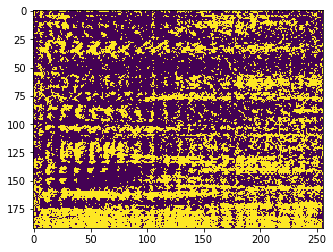

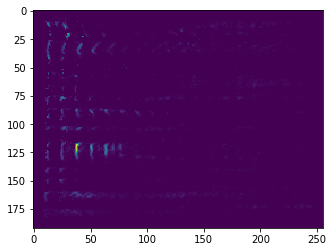

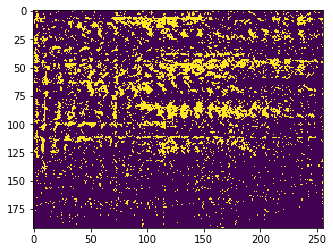

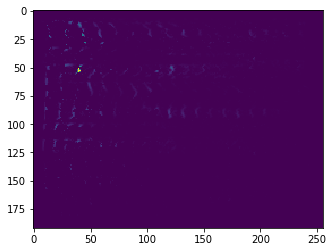

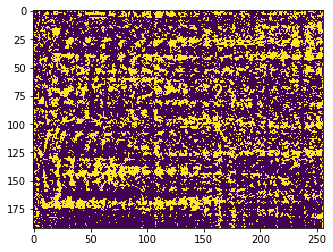

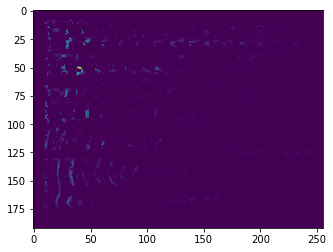

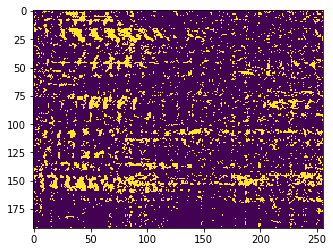

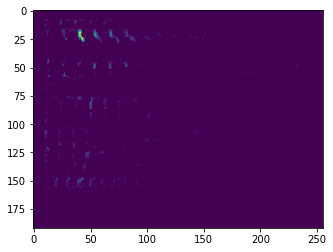

(4, 192, 256)
[4, 1]


In [17]:
labels = labels.reshape([time, freq])
ref_data = tfbins[0]
datas = []
print(ref_data.shape)
for i in range(k):
    plt.imshow((labels==i).astype(int))
    plt.show()
    local_data = ref_data*(labels==i).astype(int)
    plt.imshow(np.abs(local_data))
    plt.show()
    datas.append(local_data)
datas = np.asarray(datas)
print(datas.shape)
print([datas.shape[0], 1])
datas = np.concatenate([np.zeros([datas.shape[0], datas.shape[1], 1]), datas], axis=-1)
datas = tf.cast(datas, tf.complex64)
audios = tf.signal.inverse_stft(
    datas,
    frame_length=512,
    frame_step=int(512*1/4),
    fft_length=512,
    window_fn=tf.signal.hann_window
)

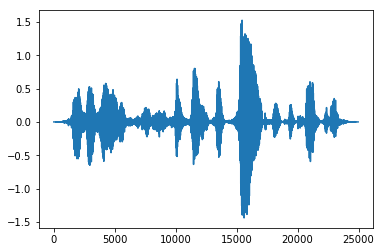

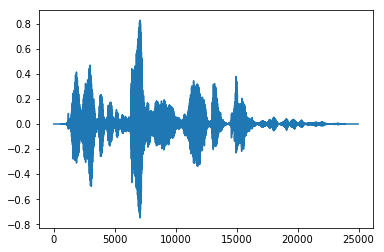

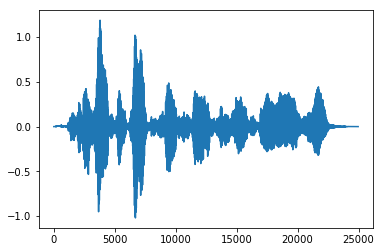

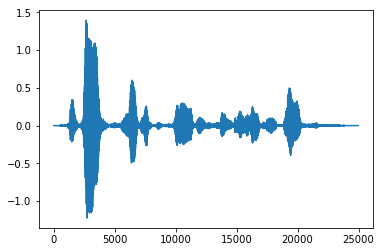

In [24]:
from scipy.io import wavfile
for i in range(4):
    plt.plot(audios[i].numpy())
    plt.show()
    wavfile.write("haha"+str(i)+".wav",8000 , data=audios[i].numpy())

In [26]:
wavfile.write("hunhe"+".wav",8000 , data=mics_signals[0].numpy())